In [272]:
# get access to the complete repo
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(),"..",".."))
main_copy_dir = os.path.join(parent_dir, "main_copy")
octagon_analysis = os.path.join(parent_dir, "octagon_analysis")
sys.path.append(main_copy_dir)
sys.path.append(octagon_analysis)

print("Added paths to sys.path", main_copy_dir, octagon_analysis)

Added paths to sys.path /Users/benny/Desktop/MSc/Project/Git/repos/main_copy /Users/benny/Desktop/MSc/Project/Git/repos/octagon_analysis


In [273]:
# imports
%load_ext autoreload
%autoreload 2

import parse_data.prepare_data as prepare_data
import analysis.opponent_visibility as opponent_visibility
import trajectory_analysis.trajectory_vectors as trajectory_vectors
import trajectory_analysis.trajectory_headangle as trajectory_headangle
import trajectory_analysis.trajectory_direction as trajectory_direction
import data_extraction.trial_list_filters as trial_list_filters
import data_extraction.get_indices as get_indices
from plotting import plot_octagon, plot_trajectory
import utils.cosine_similarity as cosine_similarity
import data_extraction.extract_trial as extract_trial
import parse_data.identify_filepaths as identify_filepaths
import analysis.loser_inferred_choice as loser_inferred_choice
import plotting.flipped_rotated_trajectory_testing_functions as flipped_rotated_trajectory_testing_functions
import plotting.wall_visibility_order_testing_functions as wall_visibility_order_testing_functions


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import globals

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [274]:
# data folder and filenames
data_folder = "/Users/benny/Desktop/MSc/Project/Git/repos/main_copy/questionnaire_analysis/pseudonymised_json_files"

social_files, ordered_solos = identify_filepaths.get_filenames(data_folder=data_folder)

In [275]:
# single json filename

json_filename = social_files[7]

In [276]:
_, trial_list = prepare_data.prepare_data(data_folder, json_filename, combine=True)

filepath: /Users/benny/Desktop/MSc/Project/Git/repos/main_copy/questionnaire_analysis/pseudonymised_json_files/250522_1/2025-05-22_09-26-39_SS22_AD22_Social.json
Loading complete.
Preprocessing complete.


In [277]:
wall_visible = trajectory_headangle.get_wall_visible(trial_list=trial_list, trial_index=7, trial=None, player_id=1, current_fov=110.36, debug=False)

In [278]:
wall_visible

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False]], shape=(8, 172))

In [ ]:
def wall_visibility_player_window(trial_list, current_fov, window=5):
    ''' 
    Returns 3D binary array for player 0 and player 1 - for wall 1 and wall 2. 
    Column length = length of the session (trial list). 
    Column entry: 1 --> wall visible between trial slice onset and end of the chosen window
    Note get_wall_visible extracts trial so that index 0 is slice onset and not trial start.
    '''
    cols = len(trial_list)
    wall_visible_list = np.full((2,2,cols), 0, dtype=int)
    walls_list = np.full((2,cols), 0, dtype=int)
    #dtype=int)
    wall_index = np.full((2,1), np.nan, dtype=int)

    for trial_index in range(len(trial_list)):
        # identify walls for each trial
        walls = get_indices.get_walls(trial=trial_list[trial_index])
        walls_list[0,trial_index] = walls[0]
        walls_list[1,trial_index] = walls[1]

        # take the wall index instead of the wall number, to index wall_visible
        wall_index[0] = walls[0] - 1
        wall_index[1] = walls[1] - 1

        for player_id in [0,1]:
          wall_visible = trajectory_headangle.get_wall_visible(trial_list=trial_list, trial_index=trial_index, trial=None, player_id=player_id, current_fov=current_fov, debug=False)
          
          for wall in [0,1]:
            print(f"checking out wall {wall}")
            if type(wall_visible) == int or type(wall_visible) == float:
              print(f"output type is {type(wall_visible)}")
              print(f"wall visible is buggy for player {player_id} in trial {trial_index}, output is: {wall_visible}")

            else:
              print(f"relevant wall is {wall_index[wall]-1}")
              print(f"printing wall visible output for player {player_id} and wall {wall} in trial {trial_index} {wall_visible[wall_index[wall],0:window]}")

              # identify which walls are initially visible
              if np.any(wall_visible[wall_index[wall],0:window]):
                  wall_visible_list[player_id,wall,trial_index] = 1
     
    return walls_list, wall_visible_list

In [290]:
walls_list, wall_visible_list = wall_visibility_player_window(trial_list, 110, window=5)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


checking out wall 0
relevant wall is [6]
printing wall visible output for player 0 and wall 0 in trial 0 [[False False False False False]]
checking out wall 1
relevant wall is [5]
printing wall visible output for player 0 and wall 1 in trial 0 [[False False False False False]]
checking out wall 0
relevant wall is [6]
printing wall visible output for player 1 and wall 0 in trial 0 [[ True  True  True  True  True]]
checking out wall 1
relevant wall is [5]
printing wall visible output for player 1 and wall 1 in trial 0 [[ True  True  True  True  True]]
checking out wall 0
relevant wall is [3]
printing wall visible output for player 0 and wall 0 in trial 1 [[ True  True  True  True  True]]
checking out wall 1
relevant wall is [7]
printing wall visible output for player 0 and wall 1 in trial 1 [[False False False False False]]
checking out wall 0
relevant wall is [3]
printing wall visible output for player 1 and wall 0 in trial 1 [[ True  True  True  True  True]]
checking out wall 1
relevan

In [291]:
wall_visible_list

array([[[0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
         1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
         1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0,
         0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
         0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
         0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
         0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1,
         0, 0, 1],
        [0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0,
         1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1,
         1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
         0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1,
         0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1,
         0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0,
         0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 

In [301]:
def plot_session_headangle_vectors_colour_map(trial_list=None, player_id=0, 
                                        vector_length=3, step=3, cmap=mpl.cm.plasma, rows=10, cols=10, trial_num_offset=0):
    '''
    Plots head angle vectors for a given player in a whole list of trials, using a color map based on timestamps.

    Parameters:
    - trial_list: List of trials
    - trial_index: Index of trial in the list
    - trial: A single trial
    - player_id: ID of the player whose head angles we want to plot
    - vector_length: Scale factor for head angle vectors
    - step: How frequently to plot head angle vectors (e.g., every 3rd point)
    - cmap: Colormap for timestamps.

    Returns:
    - ax: Updated axis with head angle vectors plotted
    '''

    fig, axes = plt.subplots(rows, cols, figsize=(20,20))

    # get walls and visibility
    walls_session, wall_visible_trial_list = wall_visibility_player_window(trial_list, 110, window=5)

    for i in range(rows):
        for j in range(cols):
            trial_index = i*rows + j + trial_num_offset

            trial = trial_list[trial_index]

            # extract trial data
            this_trial = extract_trial.extract_trial(trial, trial_list, trial_index)

            trajectory = trajectory_vectors.extract_trial_player_trajectory(trial=trial, player_id=player_id)

            # extract head angles for the player
            headangles = trajectory_vectors.extract_trial_player_headangles(trial=this_trial, player_id=player_id)
            print(f"debugging: headangles are length {len(headangles)}")

            # get smoothed head angle vectors
            trial_player_headangles_smoothed = trajectory_headangle.get_smoothed_player_head_angle_vectors_for_trial(headangles, window_size=5)
            print(f"debugging: trial_player_headangles_smoothed are length {len(trial_player_headangles_smoothed)}")

            # generate timestamps
            timestamps = np.arange(trial_player_headangles_smoothed.shape[1])
            print(f"debugging: timestamps are length {len(timestamps)}")

            if len(timestamps) > 0:

                # normalize timestamps for colormap
                norm = mpl.colors.Normalize(vmin=min(timestamps), vmax=max(timestamps))
                color_map = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)

                # plot octagon
                ax = plot_octagon.plot_octagon(ax=axes[i,j])

                # scatter trajectory
                ax.scatter(trajectory[0,:], trajectory[1,:], s=0.5)

                # plot head angle vectors at specified intervals with colormap
                for time_index in range(0, trial_player_headangles_smoothed.shape[1], step):
                    x_start = trajectory[0,time_index]
                    y_start = trajectory[1,time_index]
                    x_gradient = trial_player_headangles_smoothed[0, time_index]
                    y_gradient = trial_player_headangles_smoothed[1, time_index]

                    start = [x_start, y_start]
                    end = [x_start + x_gradient * vector_length, y_start + y_gradient * vector_length]

                    this_head_angle_vector_coordinates = np.array([start, end])
                    print(f"head angle vector coords {this_head_angle_vector_coordinates}")

                    # taking x and y coordinates for start and end of vector
                    ax.plot(this_head_angle_vector_coordinates[:, 0], 
                            this_head_angle_vector_coordinates[:, 1], 
                            c=color_map.to_rgba(timestamps[time_index]), linewidth=1.3)

                # plot first smoothed head angle in red
                x_start = trajectory[0,0]
                y_start = trajectory[1,0]
                x_gradient = trial_player_headangles_smoothed[0, 0]
                y_gradient = trial_player_headangles_smoothed[1, 0]

                start = [x_start, y_start]
                end = [x_start + x_gradient * vector_length*4, y_start + y_gradient * vector_length*4]

                this_head_angle_vector_coordinates = np.array([start, end])
                ax.plot(this_head_angle_vector_coordinates[:, 0], 
                            this_head_angle_vector_coordinates[:, 1], 
                            c="red", linewidth=1.3)

                # plot active walls
                alcove_coordinates = plot_octagon.return_alcove_centre_points()
                walls = get_indices.get_walls(trial=this_trial)
                wall1_index = walls[0] - 1
                wall2_index = walls[1] - 1

                # Use ax.scatter() to plot walls on the correct axis
                ax.scatter(alcove_coordinates[0, wall1_index], alcove_coordinates[1, wall1_index], c='r', s=50, zorder=5)
                ax.scatter(alcove_coordinates[0, wall2_index], alcove_coordinates[1, wall2_index], c='b', s=50, zorder=5)

                # hide spines and ticks
                for spine in ax.spines.values():
                    spine.set_visible(False)
                ax.tick_params(left=False, bottom=False)
                ax.set_xticklabels([])
                ax.set_yticklabels([])
            
            active_wall_visible[trial_index] = [
                [walls_session[0][trial_index], wall_visible_trial_list[player_id][0][trial_index]],
                [walls_session[1][trial_index], wall_visible_trial_list[player_id][1][trial_index]]
            ]

    plt.tight_layout()

    plt.show()

    return active_wall_visible

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/_core/numeric.py:353: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


checking out wall 0
relevant wall is [5]
printing wall visible output for player 0 and wall 0 in trial 0 [[False False False False False]]
checking out wall 1
relevant wall is [4]
printing wall visible output for player 0 and wall 1 in trial 0 [[False False False False False]]
checking out wall 0
relevant wall is [5]
printing wall visible output for player 1 and wall 0 in trial 0 [[ True  True  True  True  True]]
checking out wall 1
relevant wall is [4]
printing wall visible output for player 1 and wall 1 in trial 0 [[ True  True  True  True  True]]
checking out wall 0
relevant wall is [2]
printing wall visible output for player 0 and wall 0 in trial 1 [[ True  True  True  True  True]]
checking out wall 1
relevant wall is [6]
printing wall visible output for player 0 and wall 1 in trial 1 [[False False False False False]]
checking out wall 0
relevant wall is [2]
printing wall visible output for player 1 and wall 0 in trial 1 [[ True  True  True  True  True]]
checking out wall 1
relevan

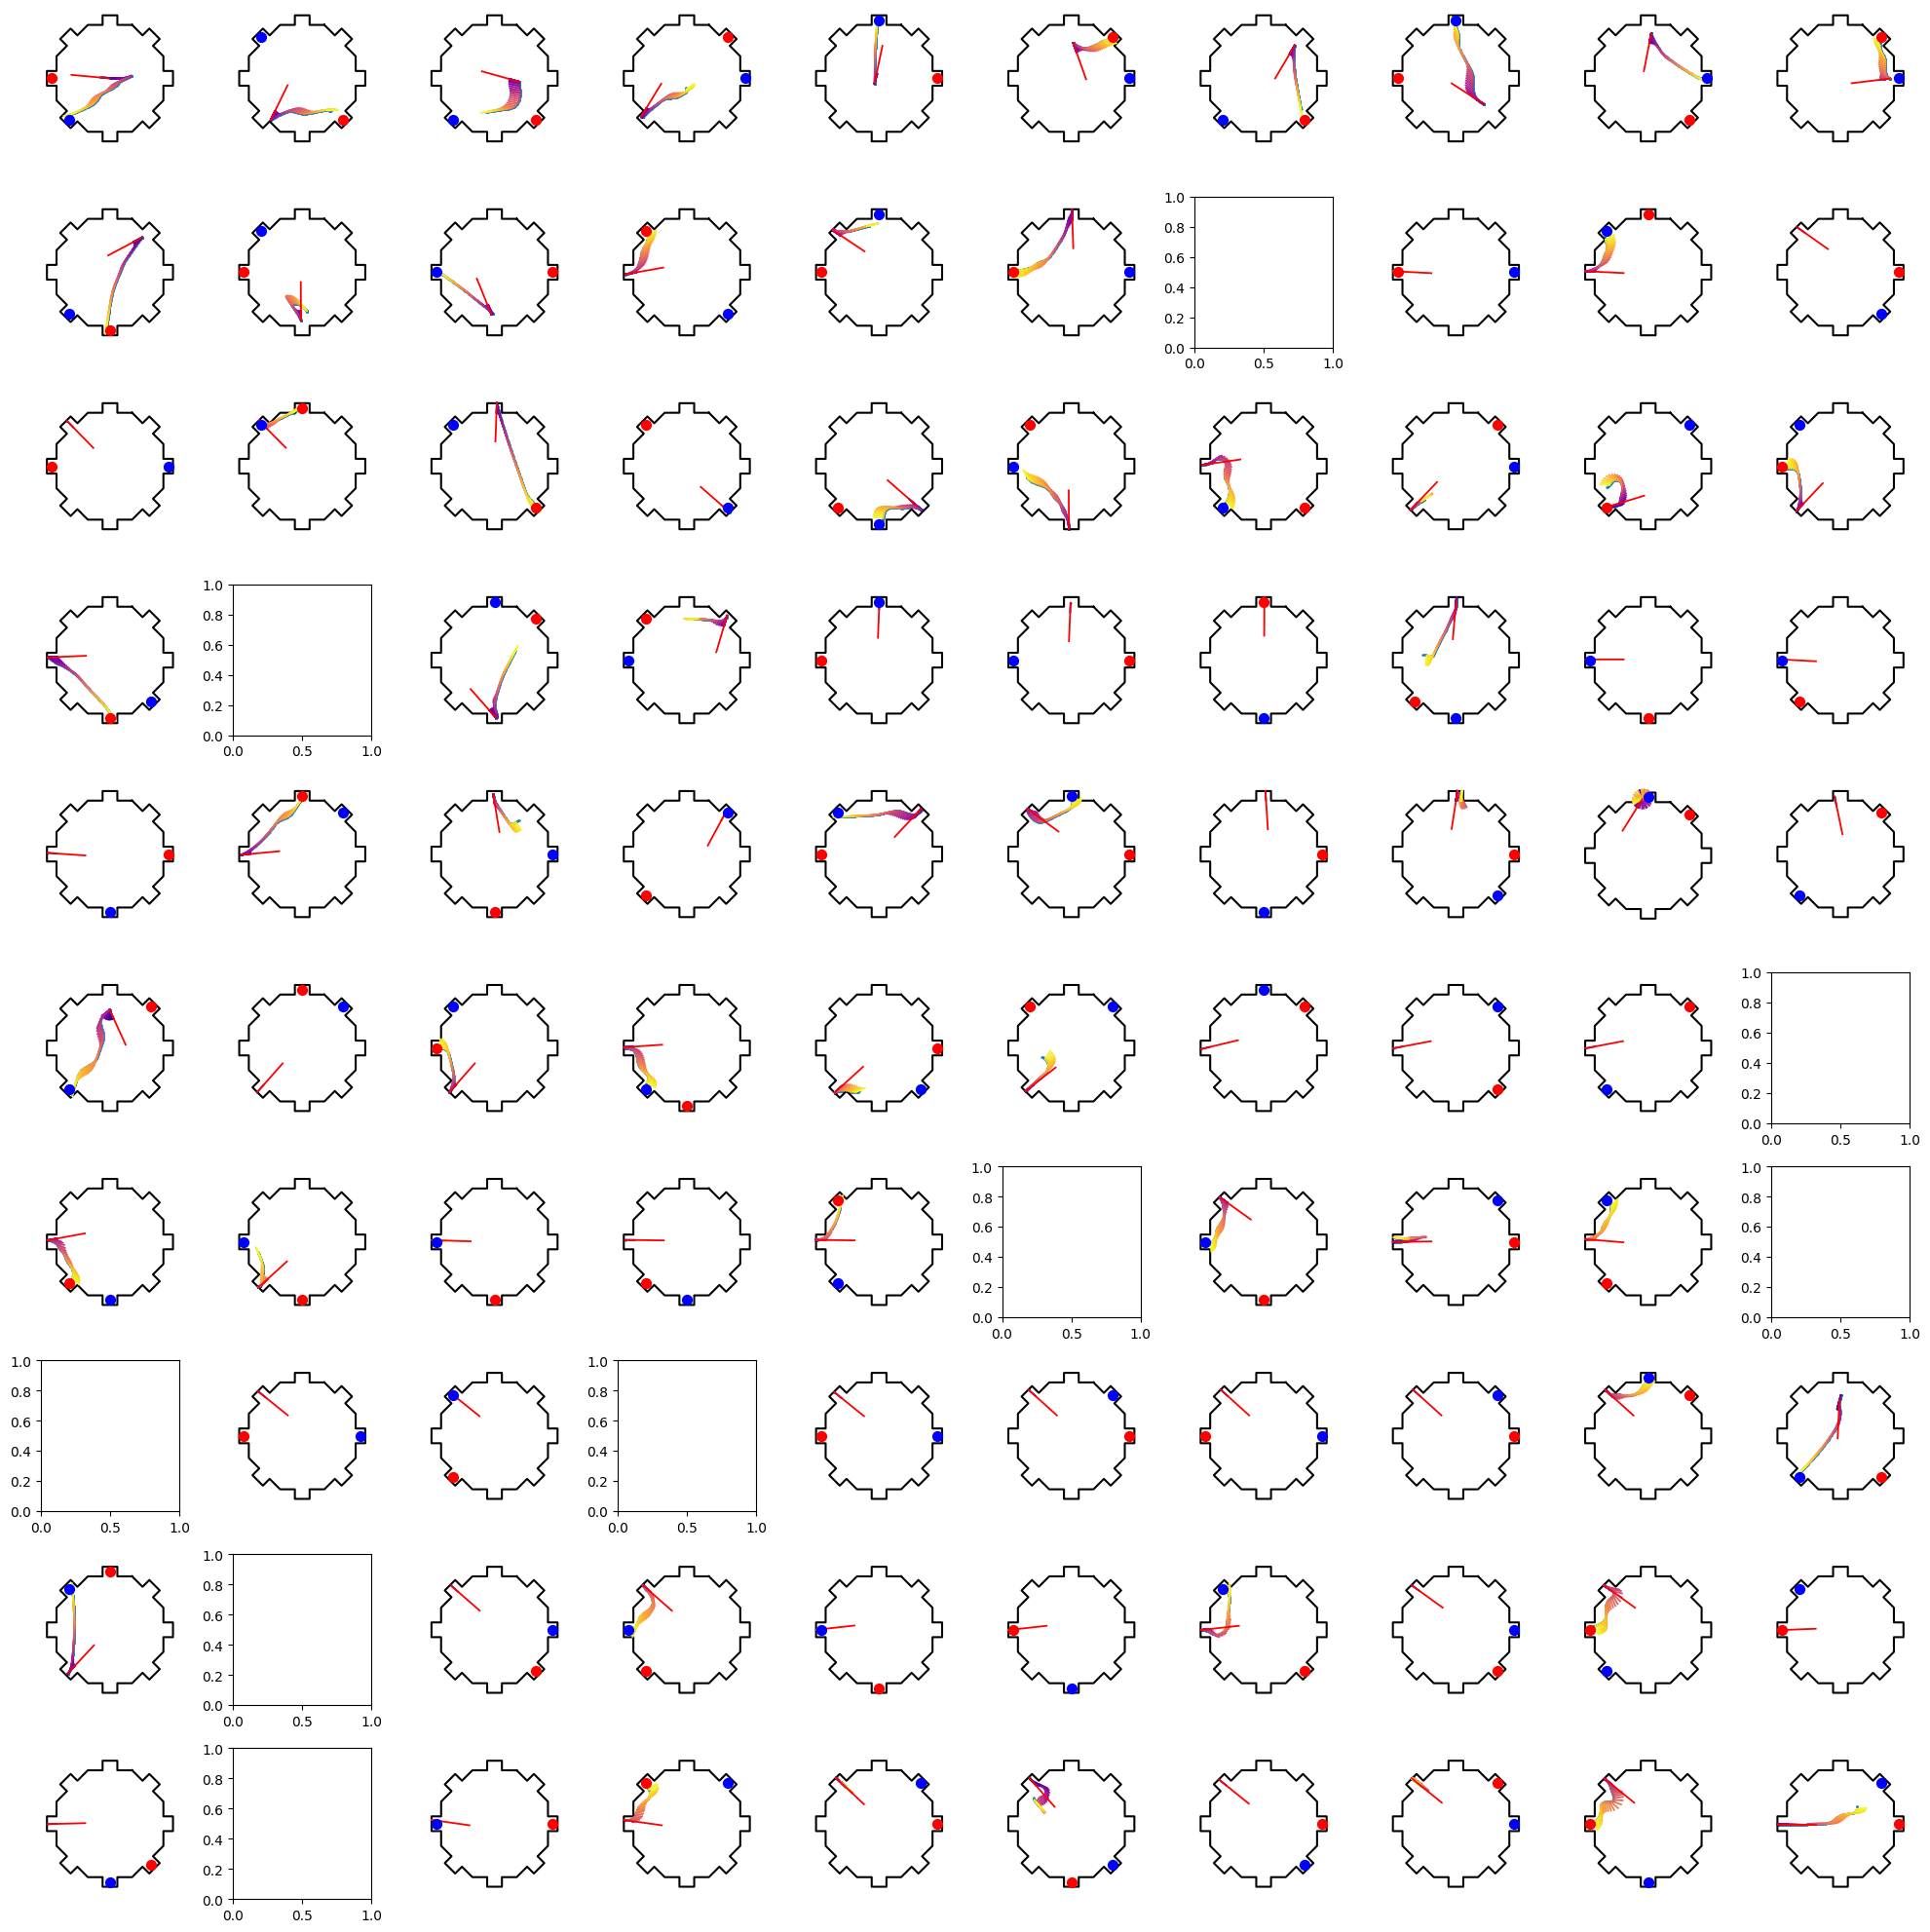

In [302]:
active_wall_visible = plot_session_headangle_vectors_colour_map(trial_list=trial_list, player_id=1, 
                                        vector_length=3, step=3, cmap=mpl.cm.plasma, rows=10, cols=10, trial_num_offset=0)

In [294]:
active_wall_visible

[[[np.int64(7), np.int64(0)], [np.int64(6), np.int64(0)]],
 [[np.int64(4), np.int64(1)], [np.int64(8), np.int64(0)]],
 [[np.int64(4), np.int64(1)], [np.int64(6), np.int64(1)]],
 [[np.int64(2), np.int64(1)], [np.int64(3), np.int64(0)]],
 [[np.int64(3), np.int64(1)], [np.int64(1), np.int64(0)]],
 [[np.int64(2), np.int64(1)], [np.int64(3), np.int64(1)]],
 [[np.int64(4), np.int64(1)], [np.int64(6), np.int64(0)]],
 [[np.int64(7), np.int64(0)], [np.int64(1), np.int64(1)]],
 [[np.int64(4), np.int64(0)], [np.int64(3), np.int64(0)]],
 [[np.int64(2), np.int64(1)], [np.int64(3), np.int64(1)]],
 [[np.int64(5), np.int64(1)], [np.int64(6), np.int64(1)]],
 [[np.int64(7), np.int64(1)], [np.int64(8), np.int64(0)]],
 [[np.int64(3), np.int64(1)], [np.int64(7), np.int64(0)]],
 [[np.int64(8), np.int64(1)], [np.int64(4), np.int64(0)]],
 [[np.int64(7), np.int64(1)], [np.int64(1), np.int64(1)]],
 [[np.int64(7), np.int64(0)], [np.int64(3), np.int64(1)]],
 [[np.int64(8), np.int64(0)], [np.int64(7), np.int64(0)]